In [1]:
%load_ext Cython
%load_ext autoreload
%autoreload 1
import numpy as np
import tensorflow as tf
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import cv2
from IPython.display import clear_output

In [2]:
def lrelu(x, alpha=.01):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

In [3]:
%%cython
import numpy as np
cimport numpy as cnp
from cython import wraparound,  boundscheck
cpdef float scaleXY(int x, int w):
    return <float> x / <float>(w-1) - .5

cdef int scaleColor(float c, float mx):
    return <int> (c * mx)

cdef float capNNOutput(float x):
    cdef float tmp = 0 if x < 0. else x
    return 1 if x > 1 else x

cpdef void draw(float[:, ::1] colors, float[:, :, ::1] image):
    cdef int W, H, index
    W = image.shape[0]
    H = image.shape[1]
    with wraparound(False), boundscheck(False):
        for w in range(W):
            for h in range(H):
                pass
                index = h + w * H
                image[w, h, 0] = colors[index, 0]
                image[w, h, 1] = colors[index, 1]
                image[w, h, 2] = colors[index, 2]

In [4]:
def createNN(inputs, schome="nn"):
    h1 = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=inputs, num_outputs=100, scope="h1")
    h2 = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=h1, num_outputs=100,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(), scope="h2")
    h3 = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=h2, num_outputs=100, scope="h3")
    h4 = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=h3, num_outputs=100, scope="h4")
    h5 = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=h4, num_outputs=100, scope="h5")
    h6 = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=h5, num_outputs=100, scope="h6")
    output = tf.contrib.layers.fully_connected(activation_fn=lrelu, inputs=h6, num_outputs=3, scope="output")
    return output

In [5]:
learning_rate = .05
tf.reset_default_graph()
inputs = tf.placeholder(shape=[None, 2], dtype=tf.float32, name="inputs")
labels = tf.placeholder(shape=[None, 3], dtype=tf.float32, name="labels")
predicted_labels = createNN(inputs, "mardas")

#loss = tf.losses.mean_squared_error(labels, predicted_labels)
diff = labels - predicted_labels
loss = tf.reduce_mean(diff*diff)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=.9)
train_op = optimizer.minimize(loss)

In [6]:
original_image = cv2.imread("/home/bzr0014/Dropbox/Photos/IMG_20140220_034619288.jpg")
original_image = cv2.imread("/home/bzr0014/git/dl4j-examples/dl4j-examples/src/main/resources/DataExamples/Mona_Lisa.png")

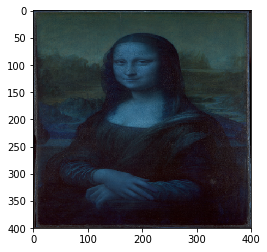

In [7]:
image = cv2.resize(original_image.copy(), (400, 400))[:,:,:3]
plt.imshow(image)

In [8]:
w,h,c = image.shape
print(w,h,c)

400 400 3


In [9]:
size = w * h
myInput = np.zeros((size, 2))
myOutput = np.zeros((size, 3))
#image = (image - image.mean()) / image.std()
image = image / image.max()
for i in range(w):
    for j in range(h):
        myInput[j + i * h, 0] = scaleXY(i, w)
        myInput[j + i * h, 1] = scaleXY(j, h)
        
        myOutput[j + i * h, :] = image[i, j]

In [10]:
num_batches = 5
batch_size = 1000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 0
    while True:
        indices = np.random.randint(size, size=num_batches*batch_size)
        for b in range(0, num_batches*batch_size, batch_size):
            this_batch = myInput[indices[b:b+batch_size]]
            this_label = myOutput[indices[b:b+batch_size]]

            this_predicted, this_loss, _ = sess.run([predicted_labels, loss, train_op], 
                                                   feed_dict={inputs: this_batch,
                                                              labels: this_label})
        total_predicted, total_loss = sess.run([predicted_labels, loss], feed_dict={inputs: myInput,
                                                                                    labels: myOutput})
        epoch += 1
        if epoch % 20:
            print("Loss: %9.8f"%total_loss)
            plt.imshow(total_predicted.reshape(w, h, 3))
            plt.show()
            clear_output(wait=True)
            

KeyboardInterrupt: 

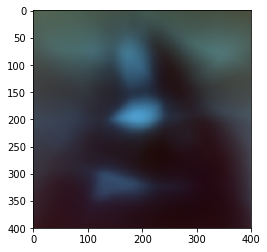

In [12]:
plt.imshow((total_predicted.reshape(w, h, 3) * 255).astype(np.uint8))